# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified national model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034).

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.visualization.output import _apply_tick_locator
from covid19model.optimization import objective_fcns, pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Load data and initialize model

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-08,6955,1470,403,295,5669,204,1.0,11.0,29,55,107
2020-11-09,7221,1474,434,145,5958,185,0.0,13.0,25,58,89
2020-11-10,7058,1470,609,708,5859,163,1.0,15.0,21,47,78
2020-11-11,6879,1463,544,626,5777,121,1.0,10.0,15,46,49
2020-11-12,7010,1452,399,242,5934,19,0.0,2.0,3,5,9


### Initialize the model without time-dependent parameters

In [4]:
from covid19model.models.time_dependant_parameter_fncs import lockdown_func

In [5]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
               'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

To calibrate the stochastic model use,

```
model = models.COVID19_SEIRD_sto(initial_states, params, time_dependent_parameters={'Nc': lockdown_func},discrete=True)
```

## Perform calibration

In [11]:
# Date of first data collection
start_date = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_beta = '2020-03-25'
# Last datapoint used to calibrate the compliance ramp
end_ramp = '2020-05-01'
# Path where figures should be stored
fig_path = '../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE'

To calibrate the stochastic model use,

```
fig_path = '../results/calibrations/COVID19_SEIRD_sto/national/'
samples_path = '../data/interim/model_parameters/COVID19_SEIRD_sto/calibrations/national/'
```

In [9]:
from covid19model.optimization.run_optimization import full_calibration_wave1
samples_dict = full_calibration_wave1(model, df_sciensano['H_in'], spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=50, popsize=50, steps_mcmc=500, discard=200)

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
Best after iteration 1: [4.92853579e+01 6.51692657e+01 3.13156979e-02] 51.9946522559561
Best after iteration 2: [4.92853579e+01 6.51692657e+01 3.13156979e-02] 51.9946522559561
New best for swarm at iteration 3: [6.96327507e+01 7.00000000e+01 2.94819381e-02] 51.157323550099484
Best after iteration 3: [6.96327507e+01 7.00000000e+01 2.94819381e-02] 51.157323550099484
New best for swarm at iteration 4: [6.14551051e+01 7.00000000e+01 2.92687650e-02] 50.96587280750394
Best after iteration 4: [6.14551051e+01 7.00000000e+01 2.92687650e-02] 50.96587280750394
Best after iteration 5: [6.14551051e+01 7.00000000e+01 2.92687650e-02] 50.96587280750394
New best for swarm at iteration 6: [6.51198084e+01 6.67285358e+01 3.05211234e-02] 50.93577648975691
Best after iteration 6: [6.51198084e+01 6.67285358e+01 3.05211234e-02] 50.93577648975691
Best after iteration 7: [6.

Process ForkPoolWorker-6:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


## Visualize fit

### $\beta$

In [8]:
# Load samples dictionary of the first wave
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/classical/BE_2020-11-05.json', 'r') as fp:
    samples_dict = json.load(fp)

<ipython-input-13-8dbf01a25c6c>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/BETA.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


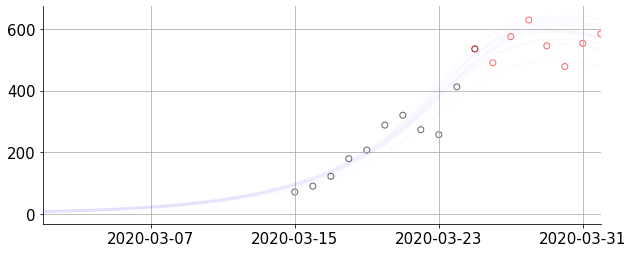

In [13]:
end_sim = '2020-04-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_date,warmup=samples_dict['warmup'])
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[:end_beta].index,df_sciensano['H_in'][:end_beta],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax.scatter(df_sciensano[end_beta:end_sim].index,df_sciensano['H_in'][end_beta:end_sim],color='red',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-01',end_sim)

plt.savefig(fig_path+'others/BETA.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### $R_0$

<ipython-input-14-7c3c253d16fa>:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


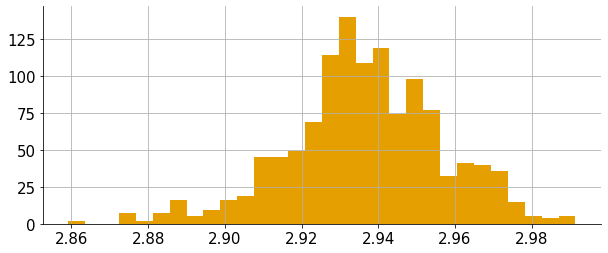

In [14]:
fig,ax=plt.subplots(figsize=(10,4))
ax.hist(samples_dict['R0'],bins=30)
plt.savefig(fig_path+'others/R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### $l$ and $\tau$

<ipython-input-15-b4692056853d>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/RAMP.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


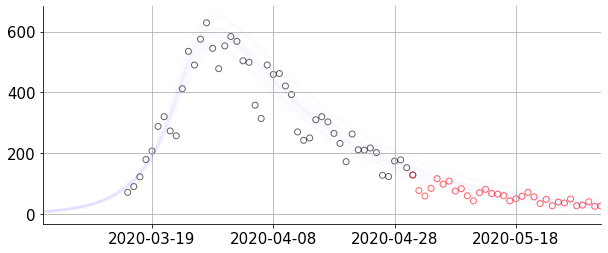

In [15]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_date,warmup=samples_dict['warmup'])
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.01)

ax.scatter(df_sciensano[:end_ramp].index,df_sciensano['H_in'][:end_ramp],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax.scatter(df_sciensano[end_ramp:end_sim].index,df_sciensano['H_in'][end_ramp:end_sim],color='red',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-01',end_sim)

plt.savefig(fig_path+'others/RAMP.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

## Other visualisations used in the preprint

### Load the posterior samples

In [ ]:
# Load previous samples
with open('../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_2020-11-05.json', 'r') as fp:
    samples_dict = json.load(fp)

### Seroprelevance

In [ ]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict,beta_only=False)
    y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'])
    ax.plot((1-y_model["S"].sel(time=end_sim)/y_model["S"].isel(time=0))*100,alpha=0.03,color='blue',linewidth=2)

ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
ax.set_ylim()
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

plt.savefig(fig_path+'others/SEROPRELEVANCE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Cumulative hospitalisations vs. $R_0$

<ipython-input-20-a9011cdaabc7>:35: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(fig_path+'others/HOSP_R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')


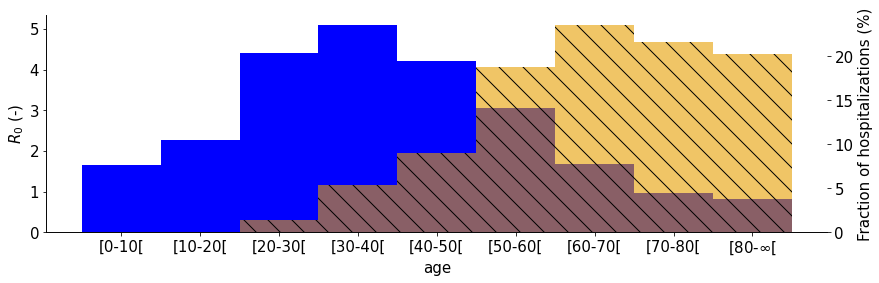

In [20]:
end_sim = '2020-05-04'
n=100

csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters = draw_sample_COVID19_SEIRD(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_date,warmup=samples_dict['warmup'])
    csum_iplus = y_model['H_in'].cumsum(dim="time")[:,-1].values
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)

R0_age = []
for key in samples_dict['R0_stratified_dict']:
    R0_age.append(np.mean(samples_dict['R0_stratified_dict'][key]))


fig,ax1=plt.subplots()

ax1.bar(np.arange(9),R0_age,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(9),csum_hosp_mean,1,alpha=0.6,hatch="\\")
ax2.set_xlabel('age')
ax2.set_ylabel('Fraction of hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

fig.set_size_inches(14, 4)
plt.savefig(fig_path+'others/HOSP_R0.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Lockdown release

In [ ]:
from covid19model.models.utils import policies_until_september

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy0': Nc_total,
              'policy1': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy2': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'policy9': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
               'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': policies_until_september})

In [ ]:
end_sim = '2020-10-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/lockdown_release.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Continuation of lockdown

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

lockdown_policy = 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure
params.update({'policy0': Nc_total,
              'policy1': lockdown_policy,
              'policy2': lockdown_policy,
              'policy3': lockdown_policy,
              'policy4': lockdown_policy,
              'policy5': lockdown_policy,
              'policy6': lockdown_policy,
              'policy7': lockdown_policy,
              'policy8': lockdown_policy,
              'policy9': lockdown_policy,
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': policies_until_september})

In [ ]:
end_sim = '2020-10-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_date,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/continued_lockdown.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### (Legacy) Re-estimating beta

In [ ]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [ ]:
def beta_reestimate_func(t,param,change_beta_time,beta_old,beta_new):
    if t <= change_beta_time:
        return beta_old
    elif change_beta_time < t <= change_beta_time+120:
        return beta_new
    else:
        return beta_new

In [ ]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

In [ ]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Add all time-dependent parameters to function definition
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
               'change_beta_time': np.mean(samples_dict['lag_time'])+50,
               'beta_old': np.mean(samples_dict['beta']),
               'beta_new': 0.06})
# Initialise the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func, 'beta': beta_reestimate_func})

In [ ]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

In [ ]:
T = 62
from copy import deepcopy
# define dataset
data=[df_sciensano["H_in"].values[:]]
# Redine lag_time
model.extraTime = samples_dict['lag_time']
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta_new'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.06)) # must be a list!

In [ ]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=smpls,maxiter=50,popsize=20)

In [ ]:
parNames = ['sigma_ICU','beta_new'] # must be a list!
bounds=((1,200),(0.0001,0.20))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,smpls))
sampler.run_mcmc(pos, 1000, progress=True);

In [ ]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [ ]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

In [ ]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

In [ ]:
samples_dict.update({'beta_new': flat_samples[:,1].tolist()})

In [ ]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [ ]:
traceplot(samples,labels=["sigma2_ICU","beta_new"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

In [ ]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta_{new}$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [ ]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

In [ ]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    model.parameters['beta_new'] = np.random.choice(samples_dict['beta_new'],1,replace=False)

    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [ ]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)